# Important Equations:
## Work:
The equation for the work done in the system can be found as:
$$W = - \int_{V_i}^{V_f}P(V)dV$$
Where the equation for pressure is:
$$P = \frac{nRT}{V}$$
Meaning work can be written as:
$$W = - nRT \int_{V_i}^{V_f} \frac{dV}{V}$$
$$W = nRT(ln(\frac{V_i}{V_f}))$$
When considering changes in temperature, the equation becomes:
$$\Delta W = nR(T_i - T_f)ln(V_i/V_f)$$

## Efficiency:
The efficiency of the system can be found as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{C_V (T_f - T_i)}{nR ln(V_f/V_i)}}$$
Where $C_V$ is:
$$C_V = \frac{nRf}{2}$$
Meaning $\eta$ can be rewritten as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{f}{2}\frac{T_f - T_i}{ln(V_f/V_i)}}$$

In [1]:
# Creating functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

# Set R as a global variable
R = 8.314

def delta_work(v_i, v_f, t_i, t_f, n):
    delta_T = t_i - t_f
    delta_w = n * R * delta_T * np.log(v_i/v_f)
    return delta_w

def work(v_i, v_f, n, T):
    work = n * R * T * (np.log(v_i/v_f))
    return work

def efficiency(t_f, t_i, v_f, v_i, f):
    efficiency = (t_f - t_i)/(t_f + (f/2)*((t_f - t_i)/(np.log(v_f/v_i))))
    return efficiency

def pressure_function(v, T, n):
    pressure = (n * R * T)/v
    return pressure

def fit_pressure(vol_data, press_data, t_est, n_est):
    # Find estimates for T and n
    p0 = [t_est, n_est]
    bounds = ([0,0], [500, 2])
    
    popt, pcov = curve_fit(pressure_function, vol_data, press_data, p0=p0, bounds=bounds)
    temp_fit, n_fit = popt
    sigma_temp, sigma_n = np.sqrt(np.diag(pcov))

    # Use values to plot pressure function against data
    p_fitted = pressure_function(vol_data, temp_fit, n_fit)
    
    plt.scatter(vol_data, press_data, label='Data', s=1, color='red')
    plt.plot(vol_data, p_fitted, label='Curve Fit', color='blue')
    plt.xlabel("Volume (m^3)")
    plt.ylabel("Pressure (Pa)")
    plt.title("Data vs. curve_fit")
    plt.legend()
    plt.show()

    print(f'Estimated temperature: {temp_fit:.2f} K +/- {sigma_temp:.2e} K')
    print(f'Estimated n: {n_fit:.2e} mol +/- {sigma_n:.2e} mol')
    
    return temp_fit, sigma_temp, n_fit, sigma_n

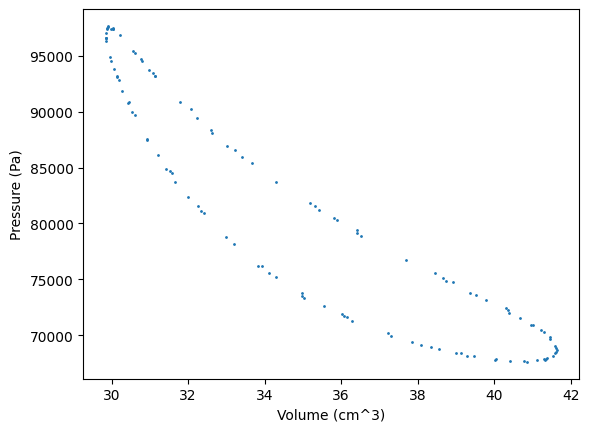

In [2]:
# Load data in dfs
df_1 = pd.read_csv("run1.csv", header=0, 
                   names=["time", "angle", "volume", "pressure","temp1", "temp2"])

time_df = df_1["time"]/1000 # s
radians = df_1["angle"]
volume = df_1["volume"] # cm^3
pressure = df_1["pressure"] * 1000 # Pa
heater_temp = df_1["temp1"] + 273.15 # K
heatsink_temp = df_1["temp2"] + 273.15 # K

plt.scatter(volume, pressure, s=1)
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (Pa)")
plt.show()

# Splitting graph into low and high pressure sections
In order to find the value for total work done in this process, we'll need to find the area of the graph between the high and low pressure sections of the graph. Or in other words, we can find the work of the high pressure section and subtract the work of the low pressure section to find only the work done between the two. In order to accomplish this, we must first split the data in half along where the data turns around in it's cycle in either direction.

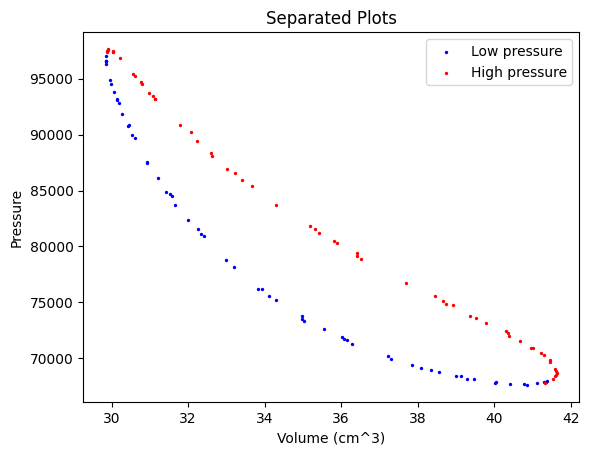

In [3]:
def lowerPresSection():
    lowSortingPres = np.zeros(len(pressure))

    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] >= pres:
                lowSortingPres[i] = pres
            elif pressure[i+1] <= pres:
                lowSortingPres[i] = 0
        else:
            lowSortingPres[i] = 0
            break

    low_pressure = []
    low_volume = []
    for i, lowPres in enumerate(lowSortingPres):
        if lowPres > 0:
            low_pressure.append(lowPres)
            low_volume.append(volume[i])

    return low_volume, low_pressure

def higherPresSection():
    highSortingPres = np.zeros(len(pressure))
    for i, pres in enumerate(pressure):
        if (i+1) <= len(pressure) - 1:
            if pressure[i+1] <= pres:
                highSortingPres[i] = pres
            elif pressure[i+1] >= pres:
                highSortingPres[i] = 0
        else:
            highSortingPres[i] = 0
            break
    high_pressure = []
    high_volume = []
    for i, highPres in enumerate(highSortingPres):
        if highPres > 0:
            high_pressure.append(highPres)
            high_volume.append(volume[i])

    return high_volume, high_pressure

low_volume, low_pressure = lowerPresSection()
high_volume, high_pressure = higherPresSection()

# Sorting plots to remove discontinuities caused by different cycles
sorted_low_pressure = sorted(zip(low_volume, low_pressure), key=lambda x: x[0])
sorted_lvolume, sorted_lpressure = zip(*sorted_low_pressure)
plt.scatter(sorted_lvolume, sorted_lpressure, s=2, color="blue")

sorted_high_pressure = sorted(zip(high_volume, high_pressure), key=lambda x: x[0])
sorted_hvolume, sorted_hpressure = zip(*sorted_high_pressure)
plt.scatter(sorted_hvolume, sorted_hpressure, s=2, color="red")

plt.title("Separated Plots")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure")
plt.legend(["Low pressure", "High pressure"])

plt.show()


# Finding error margins with curve_fit
Now that we have the high and low pressure regions plotted separately, we can use the fit_pressure function defined earlier along with the values measured by the thermocouples to find values for T and n alongside error estimates. 

As the system was heating for multiple minutes before the data collection began, and as the system is not ideal, the temperature doesn't fluctuate in the way it might be expected to under the ideal gas law. Instead, when plotted against time, the temperature of the thermocouple closer to the heat source rises continuously while the thermocouple attached to the heat sink has more of a square-wave depiction. However, both of the graphs barely fluctuate in temperature at all, and only by steps related to the sensitivity of the detectors. As a result, we'll plot the temperatures here and then use their average values to estimate n.

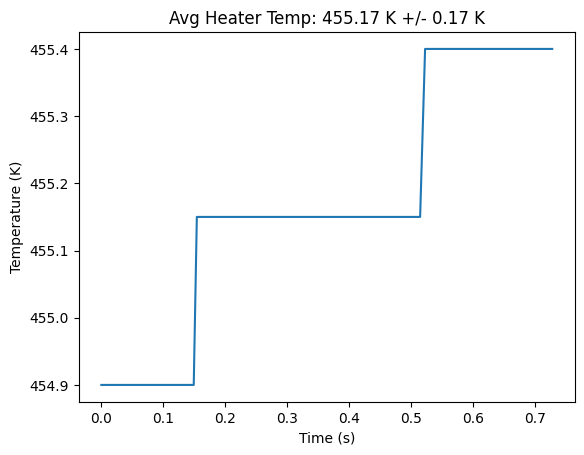

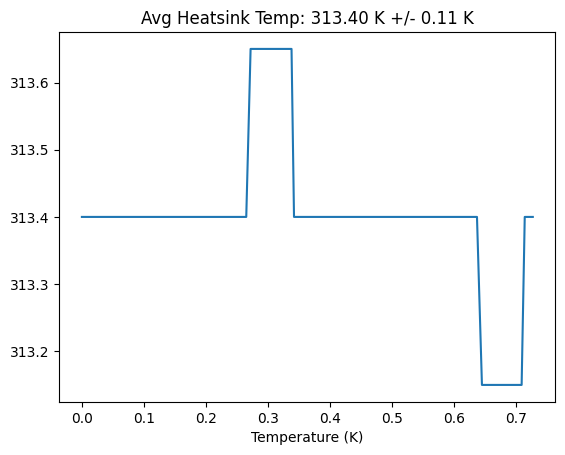

In [4]:
# Plotting temperature/time plots
avg_heater_temp = np.mean(heater_temp)
heater_temp_std = np.std(heater_temp)
plt.plot(time_df, heater_temp)
plt.xlabel(f'Time (s)')
plt.ylabel(f'Temperature (K)')
plt.title(f'Avg Heater Temp: {avg_heater_temp:.2f} K +/- {heater_temp_std:.2f} K')
plt.show()

avg_heatsink_temp = np.mean(heatsink_temp)
heatsink_temp_std = np.std(heatsink_temp)
plt.plot(time_df, heatsink_temp)
plt.xlabel(f'Time (s)')
plt.xlabel(f'Temperature (K)')
plt.title(f'Avg Heatsink Temp: {avg_heatsink_temp:.2f} K +/- {heatsink_temp_std:.2f} K')
plt.show()

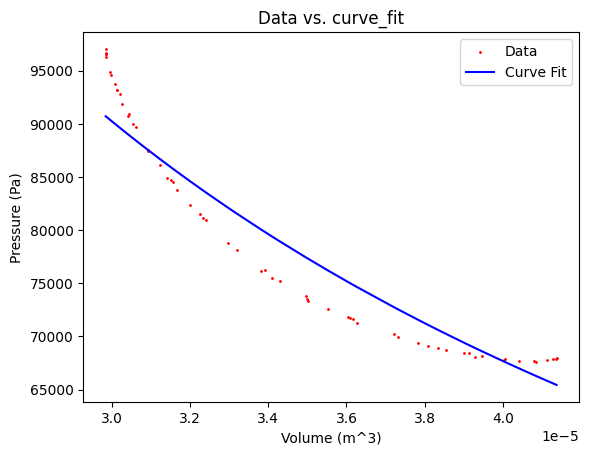

Estimated temperature: 455.18 K +/- 5.54e-12 K
Estimated n: 7.15e-04 mol +/- 3.53e-06 mol


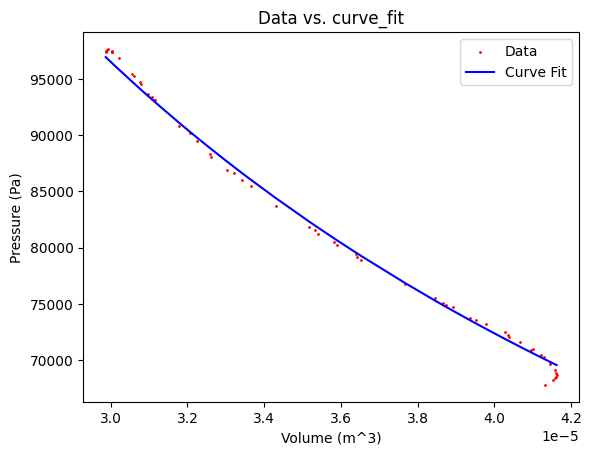

Estimated temperature: 455.16 K +/- 1.36e-12 K
Estimated n: 7.65e-04 mol +/- 8.08e-07 mol

Work on low pressure section of graph: 0.88 J
Work on high pressure section of graph: 0.96 J
Total work: 7.71e-02 J


In [14]:
# Performing curve_fit

# convert volume from cm^3 to m^3 for low and high pressure graphs
sorted_lvolume_converted = np.array(sorted_lvolume)
sorted_lvolume_converted = sorted_lvolume_converted / 1e6

sorted_hvolume_converted = np.array(sorted_hvolume)
sorted_hvolume_converted = sorted_hvolume_converted / 1e6

n_est = 0.0007
low_temp_fit, low_sigma_temp, low_n_fit, low_sigma_n = fit_pressure(sorted_lvolume_converted, sorted_lpressure, avg_heater_temp, n_est)

v_i_low_press = np.min(sorted_lvolume_converted)
v_f_low_press = np.max(sorted_lvolume_converted)

high_temp_fit, high_sigma_temp, high_n_fit, high_sigma_n = fit_pressure(sorted_hvolume_converted, sorted_hpressure, avg_heater_temp, n_est)

v_i_high_press = np.min(sorted_hvolume_converted)
v_f_high_press = np.max(sorted_hvolume_converted)

low_work = work(v_i_low_press, v_f_low_press, low_n_fit, avg_heater_temp)
high_work = work(v_i_high_press, v_f_high_press, high_n_fit, avg_heater_temp)
# For some reason, the values are coming out negative
low_work, high_work = -low_work, -high_work
engine_work = high_work - low_work
print(f'\nWork on low pressure section of graph: {low_work:.2f} J')
print(f'Work on high pressure section of graph: {high_work:.2f} J')
print(f'Total work: {engine_work:.2e} J')

# Comparing to an interpolated model

Work done by Stirling Engine: 9.43e-02 J


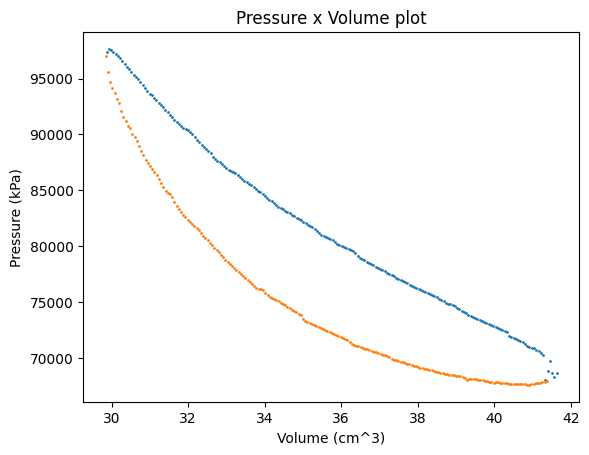

The difference between the two calculated works is only: 1.72e-02 J


In [6]:
v_i, v_f = sorted_lvolume[0], sorted_lvolume[-1]
p_i, p_f = sorted_lpressure[0], sorted_lpressure[-1]

interpVolHigh = np.linspace(sorted_hvolume[0], sorted_hvolume[-1], 200)

interpPresHigh = np.interp(interpVolHigh, sorted_hvolume, sorted_hpressure)

interpVolLow = np.linspace(sorted_lvolume[0], sorted_lvolume[-1], 200)

interpPresLow = np.interp(interpVolLow, sorted_lvolume, sorted_lpressure)

def workFunction(pressure, volume):

    deltaVolume = np.diff(volume)
    deltaVolume = np.append(deltaVolume, deltaVolume[-1])

    resultWork = np.dot(pressure, deltaVolume)  #10^2 is for converting the volume from cm to m

    resultWork = resultWork /10**(6)

    return resultWork

resultWork = workFunction(interpPresHigh, interpVolHigh)- workFunction(interpPresLow, interpVolLow)

print(f"Work done by Stirling Engine: {resultWork:.2e} J")

plt.scatter(interpVolHigh, interpPresHigh, s=1)
plt.scatter(interpVolLow, interpPresLow, s=1)
plt.title("Pressure x Volume plot")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (kPa)")
plt.show()

print(f'The difference between the two calculated works is only: {resultWork - engine_work:.2e} J')

# Finding $T_i$ and $T_f$:
In order to accurately determine the work done by the engine, it will be necessary to calculate the initial and final temperatures as the engine performs (initial and final corresponding to the minimum and maximum compression states of the piston respectively). As shown earlier, the temperatures as recorded **don't** change their values significantly through the experiment. This means that we either should estimate a $T_f - T_i$ which is approaching 0, or we should try to model how the temperatures would evolve in an ideal scenario. The first approach is easier if we substitue the initial and final values using the standard deviation of the recorded temperature values. In this way, we can simply assume $T_f - T_i = 2\sigma _T$.

Other than that, we also need to decide on a value for $f$, which is described as the total degrees of freedom available to the particles in the gas. In a monatomic gas, $f$ is essentially 3, accounting for the x, y, and z axes that a particle can move through, as rotational freedom would be neglible.

Recalling that the equation for efficiency, $\eta$, can be written as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{f}{2}\frac{T_f - T_i}{ln(V_f/V_i)}}$$
We can then plug in our values and calculate.

In [13]:
delta_T = 2 * heater_temp_std
temp_f = avg_heater_temp + heater_temp_std
f = 3

result = delta_T/(temp_f + ((f / 3) * (delta_T/np.log(v_f_high_press/v_i_high_press))))
print(f'Efficiency = {result * 100:.4f}%')


Efficiency = 0.0731%


Now we can try plotting how the temperature would evolve in a more ideal set up. To do this, we can plot:
$$T = PV/nR$$ 
Against our volume data in order to visualize how the temperature would change while the piston moves.

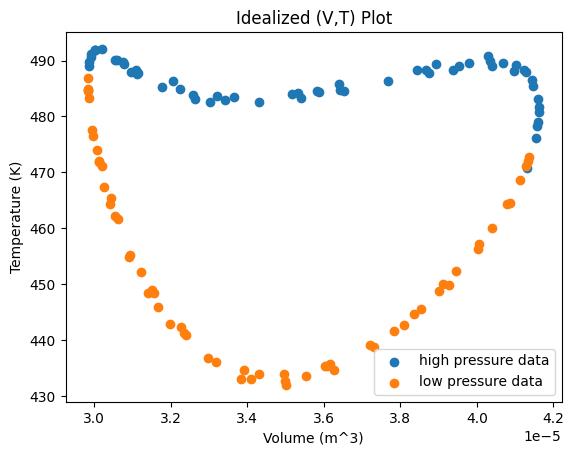

Low pressure region:
(Initial volume) t_i: 486.95
(Final volume) t_f: 472.80

High pressure region:
(Initial volume) t_i: 489.08
(Final volume) t_f: 480.76

Averaging these values, we find:
t_i: 479.87
t_f: 484.92


In [16]:
low_press_temp_function = (sorted_lpressure * sorted_lvolume_converted) / (low_n_fit * R)

high_press_temp_function = (sorted_hpressure * sorted_hvolume_converted) / (low_n_fit * R)

plt.scatter(sorted_hvolume_converted, high_press_temp_function, label="high pressure data")
plt.xlabel('Volume (m^3)')
plt.ylabel('Temperature (K)')

plt.scatter(sorted_lvolume_converted, low_press_temp_function, label="low pressure data")
plt.xlabel('Volume (m^3)')
plt.ylabel('Temperature (K)')
plt.title("Idealized (V,T) Plot")
plt.legend()
plt.show()

# Finding temperature values at low and high volumes

low_min_vol_idx, low_max_vol_idx = np.argmin(sorted_lvolume_converted), np.argmax(sorted_lvolume_converted)
high_min_vol_idx, high_max_vol_idx = np.argmin(sorted_hvolume_converted), np.argmax(sorted_hvolume_converted)

low_min_vol_temp, low_max_vol_temp = low_press_temp_function[low_min_vol_idx], low_press_temp_function[low_max_vol_idx]
high_min_vol_temp, high_max_vol_temp = high_press_temp_function[high_min_vol_idx], high_press_temp_function[high_max_vol_idx]

print('Low pressure region:')
print(f'(Initial volume) t_i: {low_min_vol_temp:.2f}\n(Final volume) t_f: {low_max_vol_temp:.2f}')
print(f'\nHigh pressure region:')
print(f'(Initial volume) t_i: {high_min_vol_temp:.2f}\n(Final volume) t_f: {high_max_vol_temp:.2f}')

t_i = (low_min_vol_temp + low_max_vol_temp)/2
t_f = (high_min_vol_temp + high_max_vol_temp)/2

print(f'\nAveraging these values, we find:\nt_i: {t_i:.2f}\nt_f: {t_f:.2f}')

In [12]:
# Finding efficiency with new temp values
v_f = v_f_high_press
v_i = v_i_high_press
result = efficiency(t_f, t_i, v_f, v_i, float(f))
print(f'New calculated efficiency value: {result * 100:.2f}%')

New calculated efficiency value: 0.99%


## Heat Conduction:
Fourier Heat Conduction Law can be used to find the conductivity of a material:
$$\frac{Q}{\Delta t}=-k_{t}A\frac{\Delta T}{\Delta x}$$
Where:
$\frac{Q}{\Delta t}$ is the rate of exchange of heat between sensors (In W, or J/S),
$k_T$ is the coefficient of thermal conductivity,
$A$ is the cross-sectional surface area between sensors (in $m^2$),
$\Delta T$ is the difference in temperature between sensors, $T_2 - T_1$ (in K), and
$\Delta x$ is the distance between the sensors (in m).

Thankfully, the power that the engine operates at is given by the product documentation as approximately 1 W, meaning that we can solve for the coefficient of thermal conductivity as:
$$k_t = - \frac{\Delta x}{\Delta T}\frac{1}{A}$$

In [ ]:
# Find delta_T across the different thermocouples

The remaining variables to be able to find the conductivity are then the cross sectional areas shared by the glass and air as well as the distance between the couples. 

The couples are rougly 8cm apart, or 0.08 m.

Assuming the glass has a thickness of 1mm and the thermocouple has a diameter of 5mm, that would mean the glass has a cross sectional surface area of $5mm^2$ or $5x10^{-6}m^2$.

The documentation for the engine says that the change in volume caused by the piston is $12cm^3$ ($1.2 x 10^{-5} m^3$), and that the path of the piston is 24mm (0.024m) long. As it traces out a cylinder, this means that we can use $V = \pi r^2 h$ where h is the length of the path to find $r=\sqrt{\frac{V}{\pi h}}$, and the additional area, $A=\pi r^2$ is equal to $4.99x10^{-4}m^2$

This gives a total cross sectional area of $5.04x10^{-4}m^2$.

In [ ]:
radius = np.sqrt(1.2e-5/(np.pi * 0.024))
air_cross_section = np.pi * (radius ** 2)

glass_thickness = 0.001
sensor_diameter = 0.005
glass_area = glass_thickness * sensor_diameter

cs_area = air_cross_section + glass_area
delta_x = 0.08 # m

print(f'Cross sectional area found as: {cs_area:.2e}m^2')

#k_t = - \frac{\Delta x}{\Delta T}\frac{1}{A}
#k_engine = - (delta_x/(temp_diff * cs_area))
#print(f'The predicted thermal conductivity of the system is approximately: {k_engine:.2f}')

Cross sectional area found as: 5.05e-04m^2
The predicted thermal conductivity of the system is approximately: 1.09
